Q-Learning with FrozenLake-v1 ⛄


Step 0: Setup a Virtual Display 💻
During the notebook, we'll need to generate a replay video. To do so, with colab, we need to have a virtual screen to be able to render the environment (and thus record the frames).

Hence the following cell will install virtual screen libraries and create and run a virtual screen 🖥

In [ ]:
%%capture
!pip install pyglet==1.5.1 
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

Step 1: Install dependencies 🔽
The first step is to install the dependencies, we’ll install multiple ones:

gym: Contains the FrozenLake-v1 ⛄ and Taxi-v3 🚕 environments.

pygame: Used for the FrozenLake-v1 and Taxi-v3 UI.

numPy: Used for handling our Q-table.

In [ ]:
%%capture
!pip install gym==0.24 # We install the newest gym version for the Taxi-v3 "rgb_array version"
!pip install pygame
!pip install numpy

!pip install huggingface_hub
!pip install pickle5
!pip install pyyaml==6.0 # avoid key error metadata
!pip install imageio imageio_ffmpeg

Step 2: Import the packages 📦
In addition to the installed libraries, we also use:

random: To generate random numbers (that will be useful for Epsilon-Greedy Policy).

imageio: To generate a replay video

In [40]:
import numpy as np
import gym
import random
import imageio
import os

import pickle5 as pickle

Part 1: Frozen Lake ⛄

We're going to train our Q-Learning agent to navigate from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H).

We can have two sizes of environment:

map_name="4x4": a 4x4 grid version

map_name="8x8": a 8x8 grid version

The environment has two modes:

is_slippery=False: The agent always move in the intended direction due to the non-slippery nature of the frozen lake.

is_slippery=True: The agent may not always move in the intended direction due to the slippery nature of the frozen lake (stochastic).

For now let's keep it simple with the 4x4 map and non-slippery

In [69]:
# Create the FrozenLake-v1 environment using 4x4 map and non-slippery version
env = gym.make("FrozenLake-v1",map_name="4x4",is_slippery=False)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's see what the Environment looks like:

In [70]:
# We create our environment with gym.make("<name_of_the_environment>")
env.reset()
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Discrete(16)
Sample observation 3


In [71]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 3


The action space (the set of possible actions the agent can take) is discrete with 4 actions available 🎮:

0: GO LEFT

1: GO DOWN

2: GO RIGHT

3: GO UP

Reward function 💰:

Reach goal: +1

Reach hole: 0

Reach frozen: 0

Step 2: Create and Initialize the Q-table 🗄️

It's time to initialize our Q-table! To know how many rows (states) and columns (actions) to use, we need to know the action and observation space. OpenAI Gym provides us a way to do that: env.action_space.n and env.observation_space.n

In [72]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  16  possible states
There are  4  possible actions


In [73]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space,action_space))
  return Qtable

In [74]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

Step 3: Define the epsilon-greedy policy 🤖
Epsilon-Greedy is the training policy that handles the exploration/exploitation trade-off.

The idea with Epsilon Greedy:

With probability 1 - ɛ : we do exploitation (aka our agent selects the action with the highest state-action pair value).

With probability ɛ: we do exploration (trying random action).

And as the training goes, we progressively reduce the epsilon value since we will need less and less exploration and more exploitation.

In [75]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_num = random.uniform(0,1)
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = np.argmax(Qtable[state])
  # else --> exploration
  else:
    action = env.action_space.sample() # Take a random action
  
  return action

Step 4: Define the greedy policy 🤖

Remember we have two policies since Q-Learning is an off-policy algorithm. This means we're using a different policy for acting and updating the value function.


Epsilon greedy policy (acting policy)

Greedy policy (updating policy)

Greedy policy will also be the final policy we'll have when the Q-learning agent will be trained. The greedy policy is used to select an action from the Q-table.

In [76]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state])
  
  return action

Step 5: Define the hyperparameters ⚙️

The exploration related hyperparamters are some of the most important ones.

We need to make sure that our agent explores enough the state space in order to learn a good value approximation, in order to do that we need to have progressive decay of the epsilon.

If you decrease too fast epsilon (too high decay_rate), you take the risk that your agent is stuck, since your agent didn't explore enough the state space and hence can't solve the problem.

In [78]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability 
decay_rate = 0.0005            # Exponential decay rate for exploration prob

Step 6: Create the training loop method

In [79]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in range(n_training_episodes):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, done, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]) 

      # If done, finish the episode
      if done:
        break
      
      # Our state is the new state
      state = new_state
  return Qtable

Step 7: Train the Q-Learning agent 🏃

In [80]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

Step 8: Let's see what our Q-Learning table looks like now 👀

In [81]:
Qtable_frozenlake

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378094, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

Step 9: Define the evaluation method 📝

In [82]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for taxi-v3)
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

Step 10: Evaluate our Q-Learning agent 📈

Normally you should have mean reward of 1.0

It's relatively easy since the state space is really small (16). What you can try to do is to replace with the slippery version.




In [83]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=1.00 +/- 0.00


Visualizing the result

Till now, we have been playing with numbers, and to give the demo, we need to create an animated Gif of the agent from the start till it reaches the goal. 

1.We will first create the state by resetting the environment with a random integer 0-500. 

2.Render the environment using rdb_array to create an image array. 

3.Then append the `img` to the `images` array. 

4.In the loop, we will take the step using the Q-Table and render the image for every step. 

5.In the end, we will use this array and imageio to create a Gif of one frame per second. 

In [84]:
def record_video(env, Qtable, out_directory, fps=1):
  images = [] 
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

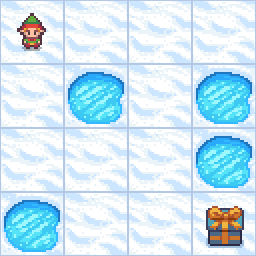

In [85]:
video_path="/content/replay.gif"
video_fps=1
record_video(env, Qtable_frozenlake, video_path, video_fps)

from IPython.display import Image
Image('./replay.gif')